Import Libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

Loading the Dataset

In [2]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date    open     high      low   close    volume  Name
129906  2015-01-30   38.15   38.655   37.690   37.73   5672192   CMS
417456  2017-07-19   23.42   24.120   23.095   24.00  10104132   NRG
468882  2017-07-26   84.69   84.723   83.620   83.70   1754183   PSX
159252  2014-09-26   82.40   83.100   82.400   82.83   2877186    DE
83873   2015-08-19  311.99  319.350  310.500  315.82   1832351  BIIB
92759   2015-12-04   42.32   43.560   42.170   43.30   1883186   BWA
279139  2017-08-21  134.94  135.770  134.500  135.57   1512552   HON


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [4]:
data['date'] = pd.to_datetime(data['date'])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


Exploratory Data Analysis

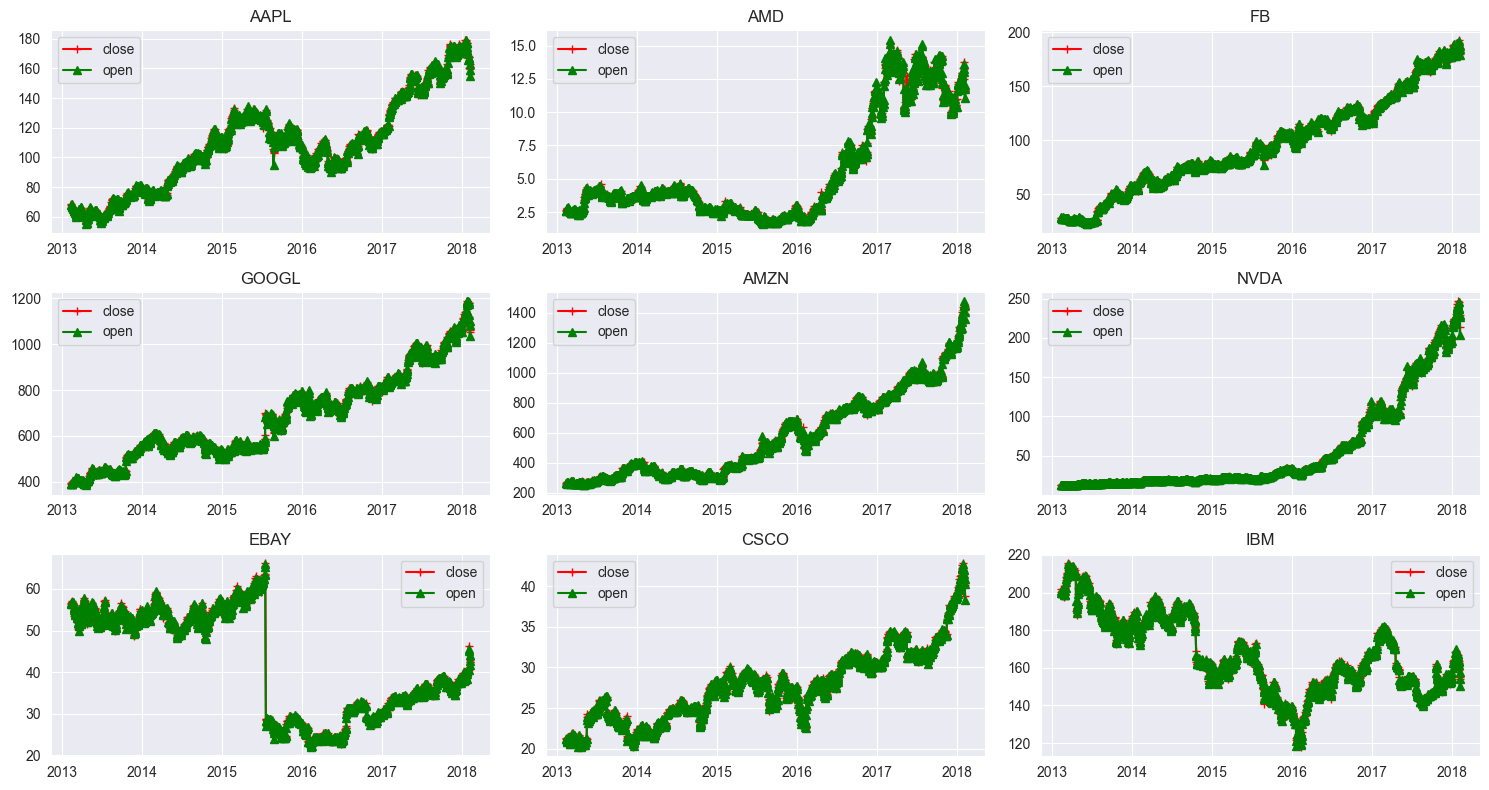

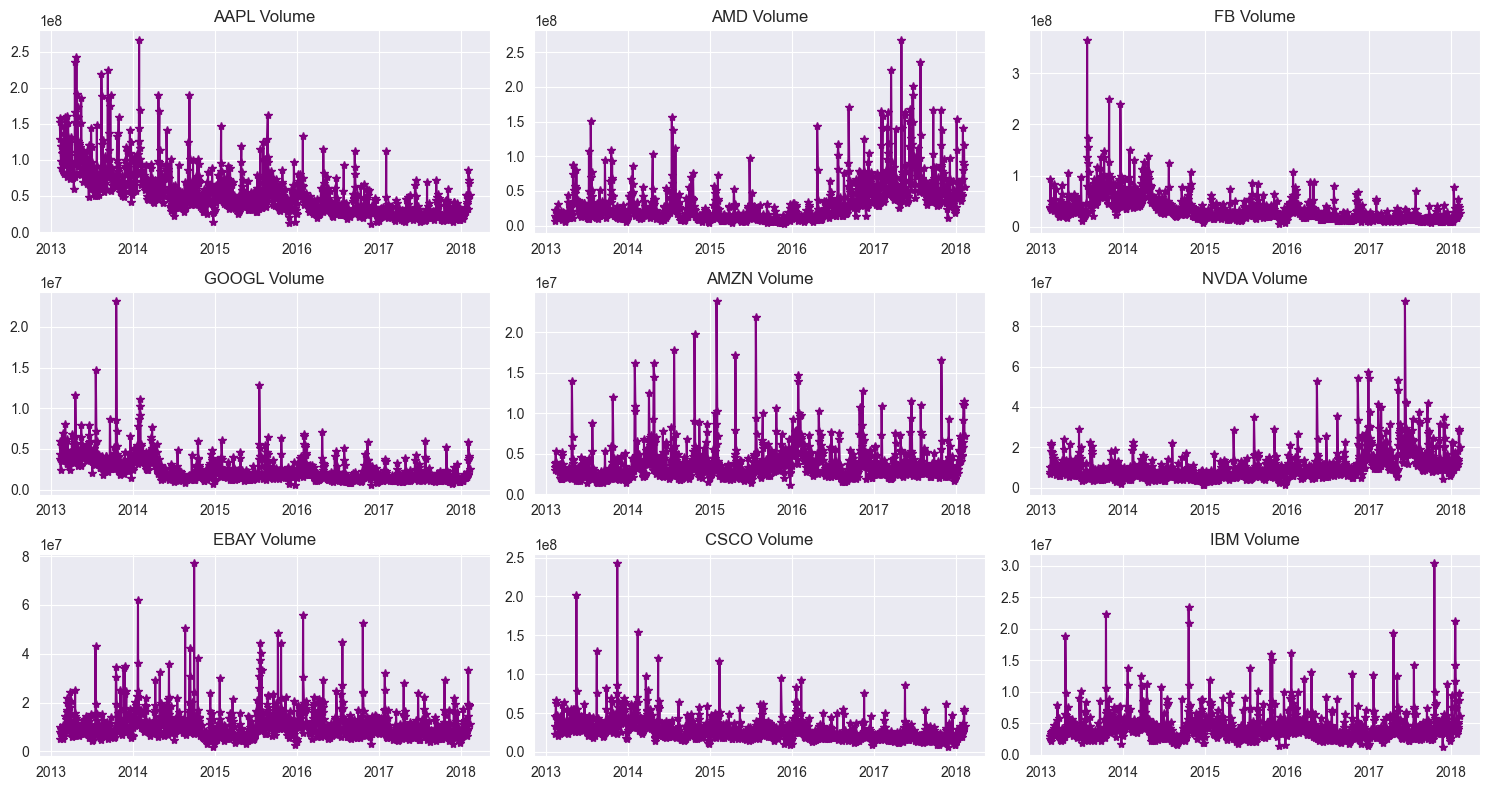

In [5]:
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM']

plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c="r", label="close", marker="+")
    plt.plot(c['date'], c['open'], c="g", label="open", marker="^")
    plt.title(company)
    plt.legend()
    plt.tight_layout()

plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['volume'], c='purple', marker='*')
    plt.title(f"{company} Volume")
    plt.tight_layout()

Volume Of Trade

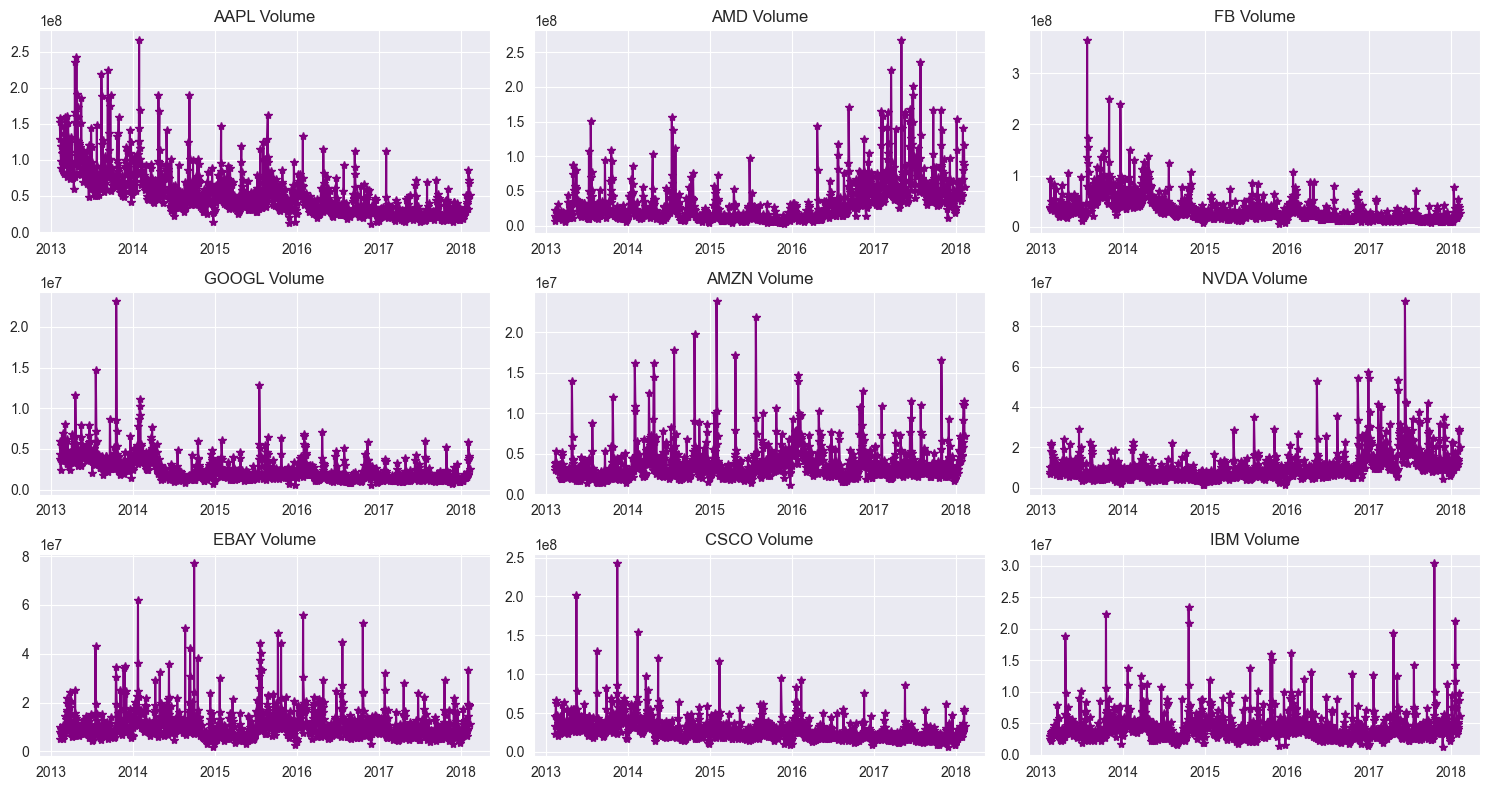

In [6]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['volume'], c='purple', marker='*')
    plt.title(f"{company} Volume")
    plt.tight_layout()

 Apple Stocks from 2013 to 2018.

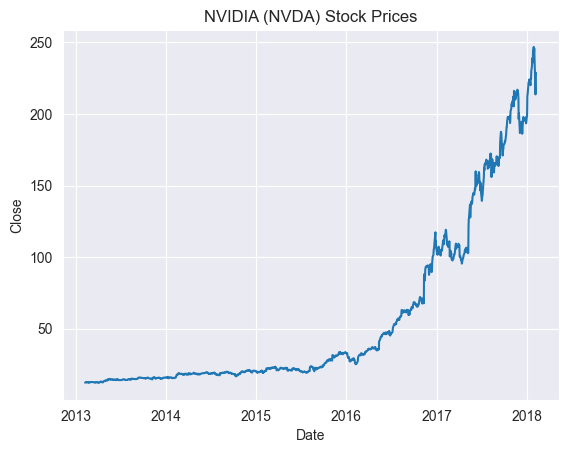

In [13]:
nvda = data[data['Name'] == 'NVDA']

# --- Prediction range (2013–2018 example) ---
prediction_range = nvda.loc[(nvda['date'] > datetime(2013,1,1)) &
                            (nvda['date'] < datetime(2018,1,1))]

plt.plot(nvda['date'], nvda['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("NVIDIA (NVDA) Stock Prices")
plt.show()

In [14]:
# --- Prepare training data ---
close_data = nvda.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


Applying scaling and preparing features and labels that are x_train and y_train.

In [16]:
from sklearn.preprocessing import MinMaxScaler

# --- Normalize ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]

x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


Build LSTM network using TensorFlow

In [17]:
from tensorflow import keras

# --- LSTM model ---
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Model Compilation and Training

In [18]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
# --- Train ---
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0298
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0031
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018


creating the testing data and then proceed with the model prediction.

In [19]:
# --- Test ---
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# --- Evaluation ---
mse = np.mean(((predictions - y_test) ** 2))
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
MSE: 293.09833771091314
RMSE: 17.120115002853023


Visualizing the final results.

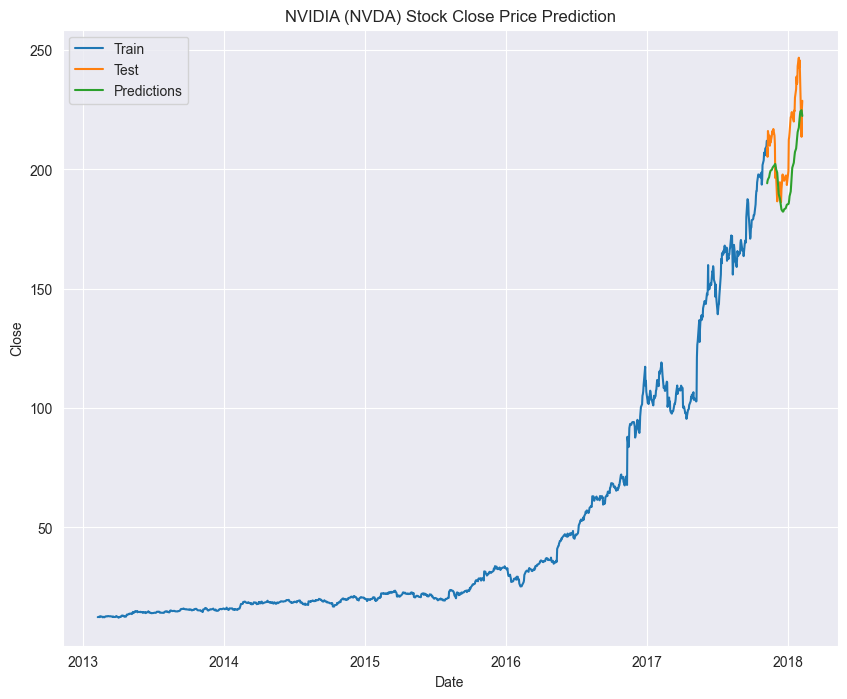

In [20]:
# --- Plot predictions ---
train = nvda[:training]
test = nvda[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('NVIDIA (NVDA) Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
plt.show()